In [6]:
from gensim.models import word2vec
import MeCab
import numpy as np
import json
import hashlib
from sklearn.cross_decomposition import CCA
from googletrans import Translator
import numpy as np
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
translator = Translator()
mt = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
mt.parse('')

'EOS\n'

In [8]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
model_doc = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")
model_word = word2vec.Word2Vec.load("wiki_plus.model")

In [51]:
def get_tags(text):
    word = {}
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if (fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞') and node.surface in model_word.wv:
            w = node.surface
            word[w] = word.get(w, 0) + 1
        node = node.next
    return word

def weighted_mean_vec(text):
    v = np.zeros(model_word.vector_size)
    s = 1.0
    for w,weight in get_tags(text).items():
        v += weight * model_word.wv[w]  #Eventクラスeの単語wの個数＊単語wのベクトル
        s += weight
    return v / s

In [52]:
def get_tags_for_doc2vec(text):
    word = []
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if node.surface in model_doc.wv and node.surface !='':
            w = node.surface
            word.append(w)
        node = node.next
    return word

In [53]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.tags = get_tags(desc)
        self.links = links
    
    def __str__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

    def __repr__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

In [54]:
class Event_doc2vec(Event):
    def __init__(self, id, type, score, desc, links):
        super().__init__(id,type,score,desc,links)
        self.tags = get_tags_for_doc2vec(desc)

In [55]:
# JSON ファイルから event set をロード
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [56]:
# JSON ファイルから event set をロード ver.doc2vec
def load_events_for_doc2vec(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event_doc2vec(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [57]:
events = load_events('sesaku2.json')
events_doc2vec = load_events_for_doc2vec('sesaku2.json')

In [58]:
events

{'8d18c23dfc91003645e65da97d421537b2ce680b': id: 8d18c23dfc91003645e65da97d421537b2ce680b type: ['製品', '発生防止', '方法', '振り返り', '対策'] score: 0.0 tags: {'機種': 1, '振り返り': 1, '実施': 1, '目標': 1, '達成': 1, '度': 1, '課題': 1, '次の一手': 1, '適用': 1, 'し': 1, 'いる': 1},
 '2be1b4d3e830c13f7bce33fdff6df8c7c5dcbbed': id: 2be1b4d3e830c13f7bce33fdff6df8c7c5dcbbed type: ['製品', '発生防止', '方法', '目標設定、マネジメント', '対策'] score: 0.0 tags: {'会社': 1, '方針': 1, '中': 1, '長期': 1, '計画': 1, '基': 1, '商品': 1, '企画': 2, '製品': 1, '経': 1, '目標': 1, '設定': 1, 'し': 1, 'いる': 1},
 '73948b65c65e9d26972fead667c2bbd02cee5caf': id: 73948b65c65e9d26972fead667c2bbd02cee5caf type: ['製品', '発生防止', '方法', '目標設定、マネジメント', '対策'] score: 0.0 tags: {'社会': 2, '調和': 1, '貢献': 1, '実現': 1, 'ビジョン': 1, 'ある': 1},
 '49bfa696aa25d321bd19ce53cd8720eb94745610': id: 49bfa696aa25d321bd19ce53cd8720eb94745610 type: ['製品', '発生防止', '方法', '目標設定、マネジメント', '対策'] score: 0.0 tags: {'経営': 1, '責任': 1, '明確化': 1},
 'da7bb983b436f3516eb708021b7c66dbff07bd13': id: da7bb983b436f3516eb7080

In [77]:
#word
class Label:
    TAISAKU = 1
    NASI = 0

data_word = []
labels_word = []
# data 
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events.items():
            if v2.type[-1] == '対策':
                x1 = weighted_mean_vec(v1.desc)
                x2 = weighted_mean_vec(v2.desc)
                data_word.extend([np.append(x1, x2)])
                if v2 in v1.links:
                    labels_word.append(Label.TAISAKU)
                else:
                    labels_word.append(Label.NASI)

In [80]:
class Label:
    TAISAKU = 1
    NASI = 0

data_doc = []
labels_doc = []
# data 
for k1, v1 in events_doc2vec.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events_doc2vec.items():
            if v2.type[-1] == '対策':
                x1 = model_doc.infer_vector(v1.tags)
                x2 = model_doc.infer_vector(v2.tags)
                data_doc.extend([np.append(x1, x2)])
                if v2 in v1.links:
                    labels_doc.append(Label.TAISAKU)
                else:
                    labels_doc.append(Label.NASI)

In [83]:
def train_data(data,labels):
    index_1 = [i for i, x in enumerate(labels) if x == 1]
    index_0 = [i for i, x in enumerate(labels) if x == 0]
    index_0 = random.sample(index_0, len(index_1))
    data_1 = [data[i] for i in index_1]
    data_0 = [data[i] for i in index_0]
    labels = [Label.TAISAKU]*len(data_1) + [Label.NASI]*len(data_0) 
    data = data_1 + data_0
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [ ]:
len(data_word)

In [84]:
data_word2,labels_word2 = train_data(data_word,labels_word)
print(data_word2.shape,labels_word2.shape)

(14648, 400) (14648,)


In [85]:
data_doc2,labels_doc2 = train_data(data_doc,labels_doc)
print(data_doc2.shape,labels_doc2.shape)

(14648, 600) (14648,)


In [86]:
def gakusyu(data,labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
    print('トレーニングデータの1の数    :',y_train.sum())
    print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
    print('テストデータの１の数            :',y_test.sum())
    print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')
    # y_train を one-hot 表現にする。
    y_train_one_hot = np_utils.to_categorical(y_train)
    y_test_one_hot = np_utils.to_categorical(y_test)
    # モデルを作成する。
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=x_train.shape[1:])) #activation
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.001), #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
        loss='categorical_crossentropy', #損失関数名
        metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

    # 学習を実行する。
    result = model.fit(x_train, y_train_one_hot , batch_size=16, epochs=30,validation_data=(x_test, y_test_one_hot )) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

    # 推論する。
    prob = model.predict(x_test, batch_size=len(x_test))

    # 最も確率が高いのを推定クラスとする。
    y_pred = np.argmax(prob, axis=1)

    # 精度を検証する。
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))
    return result, accuracy, model, x_test, y_test_one_hot

In [87]:
def miss_count(miss_count,x_test, y_test,typ = 'word'):
    prob = model.predict(x_test, batch_size=len(x_test))
    y_pred = np.argmax(prob, axis=1)
    for i,v in enumerate(y_pred):
        if np.argmax(y_test[i]) != v:
            if typ =='word':
                miss_count[data_dict_word[tuple(x_test[i])]] += 1
            else:
                miss_count[data_dict_doc[tuple(x_test[i])]] += 1
    return miss_count

In [88]:
history = {'word2vec':0,'doc2vec':0,'w_count':0,'d_count':0}
word_result = []
doc_result = []

In [89]:
for i in range(10):
    data_word2, labels_word2= train_data(data_word,labels_word)
    result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)
    history['word2vec'] = history['word2vec'] + accuracy
    history['w_count'] += 1
    word_result.append(result)

トレーニングデータの1の数    : 6584
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 740
テストデータの1の割合          : 50.5 %
Epoch 1/30
824/824 [==============================] - 1s 861us/step - loss: 0.3721 - accuracy: 0.8347 - val_loss: 0.1985 - val_accuracy: 0.9126
Epoch 2/30
824/824 [==============================] - 1s 737us/step - loss: 0.2098 - accuracy: 0.9200 - val_loss: 0.1732 - val_accuracy: 0.9365
Epoch 3/30
824/824 [==============================] - 1s 758us/step - loss: 0.1762 - accuracy: 0.9346 - val_loss: 0.2037 - val_accuracy: 0.9078
Epoch 4/30
824/824 [==============================] - 1s 704us/step - loss: 0.1618 - accuracy: 0.9408 - val_loss: 0.1507 - val_accuracy: 0.9522
Epoch 5/30
824/824 [==============================] - 1s 708us/step - loss: 0.1459 - accuracy: 0.9463 - val_loss: 0.1336 - val_accuracy: 0.9577
Epoch 6/30
824/824 [==============================] - 1s 699us/step - loss: 0.1326 - accuracy: 0.9498 - val_loss: 0.1389 - val_accuracy: 0.9454
Epoch 7/30
824/824 [========

Epoch 21/30
824/824 [==============================] - 1s 715us/step - loss: 0.0722 - accuracy: 0.9726 - val_loss: 0.0579 - val_accuracy: 0.9795
Epoch 22/30
824/824 [==============================] - 1s 713us/step - loss: 0.0737 - accuracy: 0.9722 - val_loss: 0.0616 - val_accuracy: 0.9809
Epoch 23/30
824/824 [==============================] - 1s 706us/step - loss: 0.0675 - accuracy: 0.9742 - val_loss: 0.0667 - val_accuracy: 0.9768
Epoch 24/30
824/824 [==============================] - 1s 701us/step - loss: 0.0712 - accuracy: 0.9733 - val_loss: 0.0710 - val_accuracy: 0.9747
Epoch 25/30
824/824 [==============================] - 1s 703us/step - loss: 0.0689 - accuracy: 0.9764 - val_loss: 0.0738 - val_accuracy: 0.9727
Epoch 26/30
824/824 [==============================] - 1s 718us/step - loss: 0.0691 - accuracy: 0.9736 - val_loss: 0.0706 - val_accuracy: 0.9754
Epoch 27/30
824/824 [==============================] - 1s 711us/step - loss: 0.0646 - accuracy: 0.9762 - val_loss: 0.0618 - val_ac

824/824 [==============================] - 1s 729us/step - loss: 0.1523 - accuracy: 0.9467 - val_loss: 0.1138 - val_accuracy: 0.9604
Epoch 6/30
824/824 [==============================] - 1s 725us/step - loss: 0.1413 - accuracy: 0.9468 - val_loss: 0.1136 - val_accuracy: 0.9597
Epoch 7/30
824/824 [==============================] - 1s 727us/step - loss: 0.1327 - accuracy: 0.9500 - val_loss: 0.1298 - val_accuracy: 0.9543
Epoch 8/30
824/824 [==============================] - 1s 733us/step - loss: 0.1269 - accuracy: 0.9540 - val_loss: 0.1006 - val_accuracy: 0.9672
Epoch 9/30
824/824 [==============================] - 1s 736us/step - loss: 0.1193 - accuracy: 0.9540 - val_loss: 0.0967 - val_accuracy: 0.9741
Epoch 10/30
824/824 [==============================] - 1s 738us/step - loss: 0.1134 - accuracy: 0.9590 - val_loss: 0.1332 - val_accuracy: 0.9317
Epoch 11/30
824/824 [==============================] - 1s 728us/step - loss: 0.1113 - accuracy: 0.9584 - val_loss: 0.0933 - val_accuracy: 0.9679
E

824/824 [==============================] - 1s 794us/step - loss: 0.0674 - accuracy: 0.9744 - val_loss: 0.0510 - val_accuracy: 0.9795
Epoch 26/30
824/824 [==============================] - 1s 766us/step - loss: 0.0616 - accuracy: 0.9765 - val_loss: 0.0469 - val_accuracy: 0.9816
Epoch 27/30
824/824 [==============================] - 1s 753us/step - loss: 0.0663 - accuracy: 0.9749 - val_loss: 0.0609 - val_accuracy: 0.9775
Epoch 28/30
824/824 [==============================] - 1s 737us/step - loss: 0.0639 - accuracy: 0.9760 - val_loss: 0.0503 - val_accuracy: 0.9816
Epoch 29/30
824/824 [==============================] - 1s 743us/step - loss: 0.0652 - accuracy: 0.9759 - val_loss: 0.0486 - val_accuracy: 0.9829
Epoch 30/30
824/824 [==============================] - 1s 733us/step - loss: 0.0599 - accuracy: 0.9767 - val_loss: 0.0481 - val_accuracy: 0.9850
accuracy: 98.50%
トレーニングデータの1の数    : 6590
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 734
テストデータの1の割合          : 50.1 %
Epoch 1/30
824/82

824/824 [==============================] - 1s 757us/step - loss: 0.1186 - accuracy: 0.9556 - val_loss: 0.0965 - val_accuracy: 0.9652
Epoch 10/30
824/824 [==============================] - 1s 747us/step - loss: 0.1124 - accuracy: 0.9571 - val_loss: 0.0913 - val_accuracy: 0.9666
Epoch 11/30
824/824 [==============================] - 1s 707us/step - loss: 0.1090 - accuracy: 0.9591 - val_loss: 0.0853 - val_accuracy: 0.9734
Epoch 12/30
824/824 [==============================] - 1s 707us/step - loss: 0.1036 - accuracy: 0.9595 - val_loss: 0.0804 - val_accuracy: 0.9747
Epoch 13/30
824/824 [==============================] - 1s 700us/step - loss: 0.0992 - accuracy: 0.9626 - val_loss: 0.0728 - val_accuracy: 0.9795
Epoch 14/30
824/824 [==============================] - 1s 705us/step - loss: 0.0883 - accuracy: 0.9650 - val_loss: 0.0733 - val_accuracy: 0.9713
Epoch 15/30
824/824 [==============================] - 1s 696us/step - loss: 0.0947 - accuracy: 0.9644 - val_loss: 0.0930 - val_accuracy: 0.96

824/824 [==============================] - 1s 728us/step - loss: 0.0625 - accuracy: 0.9759 - val_loss: 0.0642 - val_accuracy: 0.9761
Epoch 30/30
824/824 [==============================] - 1s 732us/step - loss: 0.0567 - accuracy: 0.9810 - val_loss: 0.0477 - val_accuracy: 0.9843
accuracy: 98.43%
トレーニングデータの1の数    : 6576
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 748
テストデータの1の割合          : 51.1 %
Epoch 1/30
824/824 [==============================] - 1s 855us/step - loss: 0.3679 - accuracy: 0.8368 - val_loss: 0.2246 - val_accuracy: 0.9181
Epoch 2/30
824/824 [==============================] - 1s 737us/step - loss: 0.2145 - accuracy: 0.9200 - val_loss: 0.2044 - val_accuracy: 0.9324
Epoch 3/30
824/824 [==============================] - 1s 697us/step - loss: 0.1748 - accuracy: 0.9369 - val_loss: 0.1658 - val_accuracy: 0.9454
Epoch 4/30
824/824 [==============================] - 1s 703us/step - loss: 0.1609 - accuracy: 0.9420 - val_loss: 0.1413 - val_accuracy: 0.9590
Epoch 5/30
824/824 [=

824/824 [==============================] - 1s 708us/step - loss: 0.0896 - accuracy: 0.9635 - val_loss: 0.1146 - val_accuracy: 0.9720
Epoch 14/30
824/824 [==============================] - 1s 703us/step - loss: 0.0918 - accuracy: 0.9639 - val_loss: 0.1116 - val_accuracy: 0.9666
Epoch 15/30
824/824 [==============================] - 1s 695us/step - loss: 0.0868 - accuracy: 0.9681 - val_loss: 0.1062 - val_accuracy: 0.9734
Epoch 16/30
824/824 [==============================] - 1s 709us/step - loss: 0.0835 - accuracy: 0.9673 - val_loss: 0.1143 - val_accuracy: 0.9686
Epoch 17/30
824/824 [==============================] - 1s 722us/step - loss: 0.0767 - accuracy: 0.9717 - val_loss: 0.1022 - val_accuracy: 0.9768
Epoch 18/30
824/824 [==============================] - 1s 714us/step - loss: 0.0809 - accuracy: 0.9688 - val_loss: 0.0996 - val_accuracy: 0.9747
Epoch 19/30
824/824 [==============================] - 1s 721us/step - loss: 0.0737 - accuracy: 0.9725 - val_loss: 0.1037 - val_accuracy: 0.97

In [90]:
for i in range(10):
    data_doc2, labels_doc2 = train_data(data_doc,labels_doc)
    result, accuracy, model,x_test, y_test = gakusyu(data_doc2, labels_doc2)
    history['doc2vec'] = history['doc2vec'] + accuracy
    history['d_count'] += 1
    doc_result.append(result)

トレーニングデータの1の数    : 6584
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 740
テストデータの1の割合          : 50.5 %
Epoch 1/30
824/824 [==============================] - 1s 916us/step - loss: 0.3607 - accuracy: 0.8443 - val_loss: 0.2136 - val_accuracy: 0.9113
Epoch 2/30
824/824 [==============================] - 1s 773us/step - loss: 0.1995 - accuracy: 0.9276 - val_loss: 0.1566 - val_accuracy: 0.9461
Epoch 3/30
824/824 [==============================] - 1s 767us/step - loss: 0.1656 - accuracy: 0.9393 - val_loss: 0.1653 - val_accuracy: 0.9372
Epoch 4/30
824/824 [==============================] - 1s 781us/step - loss: 0.1433 - accuracy: 0.9468 - val_loss: 0.1245 - val_accuracy: 0.9529
Epoch 5/30
824/824 [==============================] - 1s 779us/step - loss: 0.1287 - accuracy: 0.9513 - val_loss: 0.1311 - val_accuracy: 0.9522
Epoch 6/30
824/824 [==============================] - 1s 781us/step - loss: 0.1171 - accuracy: 0.9589 - val_loss: 0.1109 - val_accuracy: 0.9584
Epoch 7/30
824/824 [========

Epoch 21/30
824/824 [==============================] - 1s 787us/step - loss: 0.0513 - accuracy: 0.9797 - val_loss: 0.0743 - val_accuracy: 0.9754
Epoch 22/30
824/824 [==============================] - 1s 786us/step - loss: 0.0490 - accuracy: 0.9813 - val_loss: 0.0795 - val_accuracy: 0.9816
Epoch 23/30
824/824 [==============================] - 1s 765us/step - loss: 0.0439 - accuracy: 0.9831 - val_loss: 0.0820 - val_accuracy: 0.9788
Epoch 24/30
824/824 [==============================] - 1s 764us/step - loss: 0.0479 - accuracy: 0.9821 - val_loss: 0.0724 - val_accuracy: 0.9782
Epoch 25/30
824/824 [==============================] - 1s 763us/step - loss: 0.0400 - accuracy: 0.9854 - val_loss: 0.0923 - val_accuracy: 0.9706
Epoch 26/30
824/824 [==============================] - 1s 752us/step - loss: 0.0413 - accuracy: 0.9839 - val_loss: 0.0760 - val_accuracy: 0.9768
Epoch 27/30
824/824 [==============================] - 1s 756us/step - loss: 0.0406 - accuracy: 0.9845 - val_loss: 0.0610 - val_ac

824/824 [==============================] - 1s 764us/step - loss: 0.1259 - accuracy: 0.9530 - val_loss: 0.0969 - val_accuracy: 0.9693
Epoch 6/30
824/824 [==============================] - 1s 750us/step - loss: 0.1147 - accuracy: 0.9585 - val_loss: 0.1215 - val_accuracy: 0.9468
Epoch 7/30
824/824 [==============================] - 1s 755us/step - loss: 0.1098 - accuracy: 0.9599 - val_loss: 0.0847 - val_accuracy: 0.9666
Epoch 8/30
824/824 [==============================] - 1s 769us/step - loss: 0.0959 - accuracy: 0.9646 - val_loss: 0.0838 - val_accuracy: 0.9679
Epoch 9/30
824/824 [==============================] - 1s 763us/step - loss: 0.0938 - accuracy: 0.9643 - val_loss: 0.1043 - val_accuracy: 0.9549
Epoch 10/30
824/824 [==============================] - 1s 766us/step - loss: 0.0889 - accuracy: 0.9672 - val_loss: 0.0778 - val_accuracy: 0.9666
Epoch 11/30
824/824 [==============================] - 1s 772us/step - loss: 0.0781 - accuracy: 0.9695 - val_loss: 0.0751 - val_accuracy: 0.9741
E

824/824 [==============================] - 1s 839us/step - loss: 0.0467 - accuracy: 0.9822 - val_loss: 0.0904 - val_accuracy: 0.9788
Epoch 26/30
824/824 [==============================] - 1s 827us/step - loss: 0.0431 - accuracy: 0.9844 - val_loss: 0.0990 - val_accuracy: 0.9768
Epoch 27/30
824/824 [==============================] - 1s 853us/step - loss: 0.0406 - accuracy: 0.9845 - val_loss: 0.1210 - val_accuracy: 0.9618
Epoch 28/30
824/824 [==============================] - 1s 813us/step - loss: 0.0405 - accuracy: 0.9855 - val_loss: 0.0930 - val_accuracy: 0.9734
Epoch 29/30
824/824 [==============================] - 1s 791us/step - loss: 0.0375 - accuracy: 0.9850 - val_loss: 0.1044 - val_accuracy: 0.9775
Epoch 30/30
824/824 [==============================] - 1s 820us/step - loss: 0.0397 - accuracy: 0.9851 - val_loss: 0.1107 - val_accuracy: 0.9754
accuracy: 97.54%
トレーニングデータの1の数    : 6611
トレーニングデータ1の割合    : 50.1 %
テストデータの１の数            : 713
テストデータの1の割合          : 48.7 %
Epoch 1/30
824/82

824/824 [==============================] - 1s 907us/step - loss: 0.0972 - accuracy: 0.9632 - val_loss: 0.0982 - val_accuracy: 0.9652
Epoch 10/30
824/824 [==============================] - 1s 881us/step - loss: 0.0938 - accuracy: 0.9648 - val_loss: 0.1004 - val_accuracy: 0.9659
Epoch 11/30
824/824 [==============================] - 1s 853us/step - loss: 0.0879 - accuracy: 0.9663 - val_loss: 0.0894 - val_accuracy: 0.9645
Epoch 12/30
824/824 [==============================] - 1s 838us/step - loss: 0.0852 - accuracy: 0.9670 - val_loss: 0.0922 - val_accuracy: 0.9618
Epoch 13/30
824/824 [==============================] - 1s 806us/step - loss: 0.0781 - accuracy: 0.9706 - val_loss: 0.0886 - val_accuracy: 0.9652
Epoch 14/30
824/824 [==============================] - 1s 817us/step - loss: 0.0782 - accuracy: 0.9687 - val_loss: 0.1035 - val_accuracy: 0.9625
Epoch 15/30
824/824 [==============================] - 1s 856us/step - loss: 0.0728 - accuracy: 0.9712 - val_loss: 0.1074 - val_accuracy: 0.95

824/824 [==============================] - 1s 887us/step - loss: 0.0506 - accuracy: 0.9813 - val_loss: 0.1398 - val_accuracy: 0.9659
Epoch 30/30
824/824 [==============================] - 1s 838us/step - loss: 0.0443 - accuracy: 0.9820 - val_loss: 0.1308 - val_accuracy: 0.9727
accuracy: 97.27%
トレーニングデータの1の数    : 6631
トレーニングデータ1の割合    : 50.3 %
テストデータの１の数            : 693
テストデータの1の割合          : 47.3 %
Epoch 1/30
824/824 [==============================] - 1s 922us/step - loss: 0.3570 - accuracy: 0.8437 - val_loss: 0.3904 - val_accuracy: 0.8246
Epoch 2/30
824/824 [==============================] - 1s 769us/step - loss: 0.1963 - accuracy: 0.9270 - val_loss: 0.1683 - val_accuracy: 0.9433
Epoch 3/30
824/824 [==============================] - 1s 809us/step - loss: 0.1568 - accuracy: 0.9418 - val_loss: 0.1804 - val_accuracy: 0.9324
Epoch 4/30
824/824 [==============================] - 1s 835us/step - loss: 0.1388 - accuracy: 0.9495 - val_loss: 0.1560 - val_accuracy: 0.9522
Epoch 5/30
824/824 [=

824/824 [==============================] - 1s 790us/step - loss: 0.0772 - accuracy: 0.9700 - val_loss: 0.1233 - val_accuracy: 0.9529
Epoch 14/30
824/824 [==============================] - 1s 767us/step - loss: 0.0700 - accuracy: 0.9728 - val_loss: 0.1355 - val_accuracy: 0.9543
Epoch 15/30
824/824 [==============================] - 1s 798us/step - loss: 0.0657 - accuracy: 0.9751 - val_loss: 0.1153 - val_accuracy: 0.9549
Epoch 16/30
824/824 [==============================] - 1s 786us/step - loss: 0.0659 - accuracy: 0.9754 - val_loss: 0.1068 - val_accuracy: 0.9638
Epoch 17/30
824/824 [==============================] - 1s 783us/step - loss: 0.0641 - accuracy: 0.9759 - val_loss: 0.1439 - val_accuracy: 0.9577
Epoch 18/30
824/824 [==============================] - 1s 766us/step - loss: 0.0559 - accuracy: 0.9801 - val_loss: 0.1210 - val_accuracy: 0.9570
Epoch 19/30
824/824 [==============================] - 1s 767us/step - loss: 0.0525 - accuracy: 0.9816 - val_loss: 0.1103 - val_accuracy: 0.95

In [91]:
word_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in word_result_all.items():
    for i in range(30):
        for j in word_result:
            v[i] += j.history[k][i]
        v[i] /= 10

doc_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in doc_result_all.items():
    for i in range(30):
        for j in doc_result:
            v[i] += j.history[k][i]
        v[i] /= 10

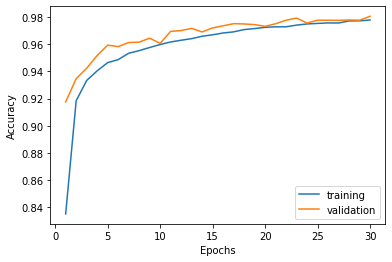

In [92]:
plt.plot(range(1, 30+1),word_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), word_result_all['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

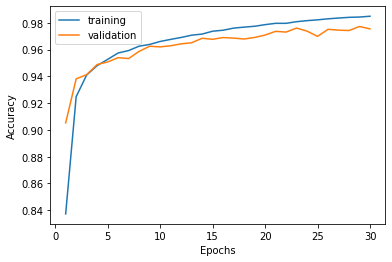

In [93]:
plt.plot(range(1, 30+1),doc_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), doc_result_all['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [96]:
data_doc2,labels_doc2= np.array(data_wo), np.array(labels_doc)
prob = model.predict(x_test, batch_size=len(data_doc2))

y_test_one_hot = np_utils.to_categorical(labels_word2)

y_pred = np.argmax(prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print('accuracy: {:.2%}'.format(accuracy))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets